In [1]:
import GAN.models as models
import GAN.cms_datasets as cms
import GAN.plotting as plotting
import GAN.preprocessing as preprocessing
import GAN.base as base

Using TensorFlow backend.


In [2]:
# import os
# os.environ

In [3]:
import GAN.utils as utils

reload(utils)

class Parameters(utils.Parameters):
    
    load_datasets=utils.param(["moriond_v9","abs(ScEta) < 1.5"])

#     c_names = utils.param(['Pt','ScEta','Phi','rho'])
#     x_names = utils.param(['R9','SigmaIeIe','S4','EtaWidth','PhiWidth','CovarianceIetaIphi',
#                'CovarianceIphiIphi', ])
    c_names = utils.param(['Phi','ScEta'])
    x_names = utils.param(['EtaWidth','R9'])
    reweight = utils.param('rewei_zee_barrel.npy')
    mcweight = utils.param('weight')
    
    feat_transform = utils.param('minmax')
    
    g_opts=utils.param(dict(name="G_128to32x7",kernel_sizes=[32]+[64]*2+[128]*2, # kernel_sizes=[128]*7,
                            # do_nl_activ="tanh",
                            do_nl_activ=["relu","tanh"]*3+["relu"],
                            do_bn=False,do_dropout=False))
    pretrain_g = utils.param(False)
    d_opts=utils.param(dict(name="D_256x5",kernel_sizes=[256]*5,do_bn=True,
                        clip_weights=2.e-2,activation=None)) # weights clipping and no actication
    #dm_opts=utils.param(dict(optimizer="RMSprop",opt_kwargs=dict(lr=0.00002, decay=6e-6)))
    #am_opts=utils.param(dict(optimizer="RMSprop",opt_kwargs=dict(lr=0.00002, decay=6e-6)))
    dm_opts=utils.param(dict(optimizer="RMSprop",opt_kwargs=dict(lr=0.00002)))#, decay=6e-6)))
    am_opts=utils.param(dict(optimizer="RMSprop",opt_kwargs=dict(lr=0.00002)))#, decay=6e-6)))
    
    
    epochs=utils.param(200)
    batch_size=utils.param(4096)
    plot_every=utils.param(10)
    
    frac_data=utils.param(10)
    
    loss = utils.param("wgan_loss") # use WGAN loss 
    gan_targets = utils.param('gan_targets_hinge') # hinge targets are 1, -1 instead of 0, 1
    schedule = utils.param([0]*5+[1]*1) # number of critic iterations per generator iterations
    
    monitor_dir = utils.param('log')
    
class MyApp(utils.MyApp):
    classes = utils.List([Parameters])

# Read all parameters above from command line. 
# Note: names are all converted to be all capital
notebook_parameters = Parameters(MyApp()).get_params()

# copy parameters to global scope
globals().update(notebook_parameters)
DM_OPTS.update( {"loss":LOSS} )
AM_OPTS.update( {"loss":LOSS} )
notebook_parameters


{'AM_OPTS': {'loss': 'wgan_loss',
  'opt_kwargs': {'lr': 2e-05},
  'optimizer': 'RMSprop'},
 'BATCH_SIZE': 4096,
 'C_NAMES': ['Phi', 'ScEta'],
 'DM_OPTS': {'loss': 'wgan_loss',
  'opt_kwargs': {'lr': 2e-05},
  'optimizer': 'RMSprop'},
 'D_OPTS': {'activation': None,
  'clip_weights': 0.02,
  'do_bn': False,
  'kernel_sizes': [256, 256, 256, 256, 256],
  'name': 'D_256x5'},
 'EPOCHS': 200,
 'FEAT_TRANSFORM': 'minmax',
 'FRAC_DATA': 10,
 'GAN_TARGETS': 'gan_targets_hinge',
 'G_OPTS': {'do_bn': False,
  'do_dropout': False,
  'do_nl_activ': ['relu', 'tanh', 'relu', 'tanh', 'relu', 'tanh', 'relu'],
  'kernel_sizes': [32, 64, 64, 128, 128],
  'name': 'G_128x7'},
 'LOAD_DATASETS': ['moriond_v9', 'abs(ScEta) < 1.5'],
 'LOSS': 'wgan_loss',
 'MCWEIGHT': 'weight',
 'MONITOR_DIR': 'log',
 'PLOT_EVERY': 10,
 'PRETRAIN_G': False,
 'REWEIGHT': 'rewei_zee_barrel.npy',
 'SCHEDULE': [0, 0, 0, 0, 0, 1],
 'X_NAMES': ['EtaWidth', 'R9']}

In [4]:
reload(cms)

data,mc = cms.load_zee(*LOAD_DATASETS)


In [5]:
data.columns

Index(['index', 'run', 'rho', 'nvtx', 'mass', 'weight', 'SigMoM', 'Pt',
       'ScEta', 'Phi', 'R9', 'S4', 'SigmaIeIe', 'EtaWidth', 'PhiWidth',
       'CovarianceIphiIphi', 'SigmaRR', 'ScEnergy', 'CovarianceIetaIphi',
       'PhoIso03', 'ChIso03', 'ChIso03worst', 'ScPreshowerEnergy', 'PhoIDMVA',
       'SigEOverE', 'run_quantile'],
      dtype='object')

In [6]:
mc.columns

Index(['index', 'run', 'rho', 'nvtx', 'mass', 'weight', 'SigMoM', 'Pt',
       'ScEta', 'Phi', 'R9', 'S4', 'SigmaIeIe', 'EtaWidth', 'PhiWidth',
       'CovarianceIphiIphi', 'SigmaRR', 'ScEnergy', 'CovarianceIetaIphi',
       'PhoIso03', 'ChIso03', 'ChIso03worst', 'ScPreshowerEnergy', 'PhoIDMVA',
       'SigEOverE'],
      dtype='object')

In [7]:
c_names = C_NAMES
x_names = X_NAMES

data_c = data[c_names]
data_x = data[x_names]

mc_c = mc[c_names]
mc_x = mc[x_names]


In [8]:
data_x.columns, data_x.shape, data_c.columns, data_c.shape

(Index(['EtaWidth', 'R9'], dtype='object'),
 (17520217, 2),
 Index(['Phi', 'ScEta'], dtype='object'),
 (17520217, 2))

In [9]:
data_x.columns, data_c.columns

(Index(['EtaWidth', 'R9'], dtype='object'),
 Index(['Phi', 'ScEta'], dtype='object'))

In [10]:
mc_x.columns, mc_c.columns

(Index(['EtaWidth', 'R9'], dtype='object'),
 Index(['Phi', 'ScEta'], dtype='object'))

In [11]:
reload(preprocessing)
if not REWEIGHT is None:
    info = np.load(REWEIGHT)
    inputs = info[0]
    weights = info[1]
    bins = info[2:]
    print(bins[1])
    mc_w = preprocessing.reweight(mc,inputs,bins,weights,MCWEIGHT)
elif MCWEIGHT is None:
    mc_w = np.ones(mc_x.shape[0])
else:
    mc_w = mc[MCWEIGHT]
    
data_w = np.ones(data_x.shape[0])

[ -3.13999963e+00  -3.01439953e+00  -2.88879967e+00  -2.76319957e+00
  -2.63759971e+00  -2.51199961e+00  -2.38639975e+00  -2.26079965e+00
  -2.13519979e+00  -2.00959969e+00  -1.88399971e+00  -1.75839972e+00
  -1.63279974e+00  -1.50719976e+00  -1.38159978e+00  -1.25599980e+00
  -1.13039982e+00  -1.00479984e+00  -8.79199803e-01  -7.53599823e-01
  -6.27999842e-01  -5.02399862e-01  -3.76799852e-01  -2.51199871e-01
  -1.25599876e-01   1.19209290e-07   1.25600114e-01   2.51200110e-01
   3.76800090e-01   5.02400100e-01   6.28000081e-01   7.53600061e-01
   8.79200041e-01   1.00480008e+00   1.13040006e+00   1.25600004e+00
   1.38160002e+00   1.50720000e+00   1.63279998e+00   1.75839996e+00
   1.88399994e+00   2.00959992e+00   2.13520002e+00   2.26079988e+00
   2.38639998e+00   2.51199985e+00   2.63759995e+00   2.76319981e+00
   2.88879991e+00   3.01439977e+00   3.13999987e+00]


In [12]:
reload(models)

xz_shape = (1,len(x_names))
c_shape = (1,len(c_names))
gan = models.MyFFGAN( xz_shape, xz_shape, c_shape=c_shape,
                     g_opts=G_OPTS,
                     d_opts=D_OPTS,
                     dm_opts=DM_OPTS,
                     am_opts=AM_OPTS,
                     gan_targets=GAN_TARGETS
                    )

In [13]:
gan.get_generator()

(1, 2)


In [14]:
gan.get_discriminator()

WeightClip 0.02
WeightClip 0.02
WeightClip 0.02
WeightClip 0.02
WeightClip 0.02
WeightClip 0.02


(<keras.engine.training.Model at 0x2ae05afd5828>,
 <keras.engine.training.Model at 0x2ae05afd5ef0>)

In [15]:
gan.adversarial_compile(loss=LOSS,schedule=SCHEDULE)

wgan_loss


In [16]:
gan.get_generator().summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
G_128x7_c_input (InputLayer)     (None, 1, 2)          0                                            
____________________________________________________________________________________________________
G_128x7_input (InputLayer)       (None, 1, 2)          0                                            
____________________________________________________________________________________________________
G_128x7_all_inputs (Concatenate) (None, 1, 4)          0           G_128x7_c_input[0][0]            
                                                                   G_128x7_input[0][0]              
____________________________________________________________________________________________________
G_128x7_up1_dense (Dense)        (None, 1, 128)        640         G_128x7_all_inputs[0][0]

In [17]:
gan.get_discriminator()[0].summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
D_256x5_c_input (InputLayer)     (None, 1, 2)          0                                            
____________________________________________________________________________________________________
D_256x5_input (InputLayer)       (None, 1, 2)          0                                            
____________________________________________________________________________________________________
D_256x5_all_inputs (Concatenate) (None, 1, 4)          0           D_256x5_c_input[0][0]            
                                                                   D_256x5_input[0][0]              
____________________________________________________________________________________________________
D_256x5_down1_dense (Dense)      (None, 1, 256)        1280        D_256x5_all_inputs[0][0]

In [18]:
gan.get_discriminator()[1].summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
D_256x5_c_input (InputLayer)     (None, 1, 2)          0                                            
____________________________________________________________________________________________________
D_256x5_input (InputLayer)       (None, 1, 2)          0                                            
____________________________________________________________________________________________________
D_256x5_all_inputs (Concatenate) (None, 1, 4)          0           D_256x5_c_input[0][0]            
                                                                   D_256x5_input[0][0]              
____________________________________________________________________________________________________
D_256x5_down1_dense (Dense)      (None, 1, 256)        1280        D_256x5_all_inputs[0][0]

In [19]:
set(gan.am[0].trainable_weights)-set(gan.am[1].trainable_weights)

set()

In [20]:
# gan.dm.summary()

In [21]:
# gan.gan.summary()

In [22]:
# gan.gan.outputs, gan.gan.inputs

In [23]:
# plotting.plot_hists(data_x.values[:,0],mc_x.values[:,0],bins=100,range=[0,1.2])
# plt.show()
# plotting.plot_hists(data_x.values[:,1],mc_x.values[:,1],bins=100,range=[0,5e-2])

In [24]:
reload(preprocessing)

data_x,data_c,mc_x,mc_c,scaler_x,scaler_c = preprocessing.transform(data_x,data_c,mc_x,mc_c,FEAT_TRANSFORM)


In [25]:
data_x.shape,mc_x.shape

((17520217, 1, 2), (9616192, 1, 2))

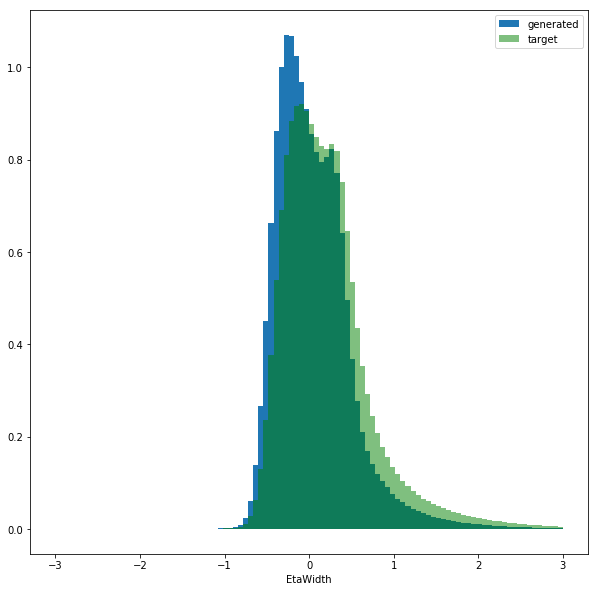

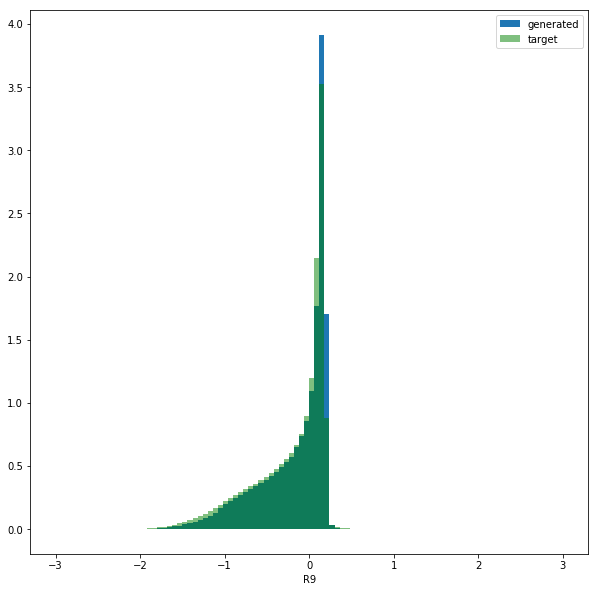

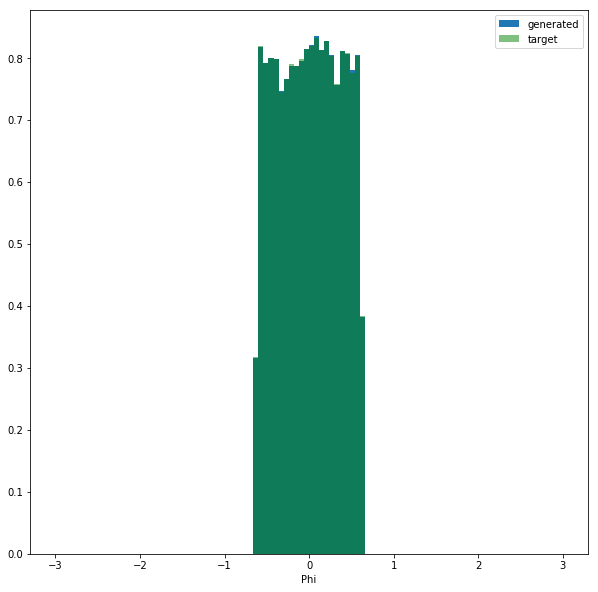

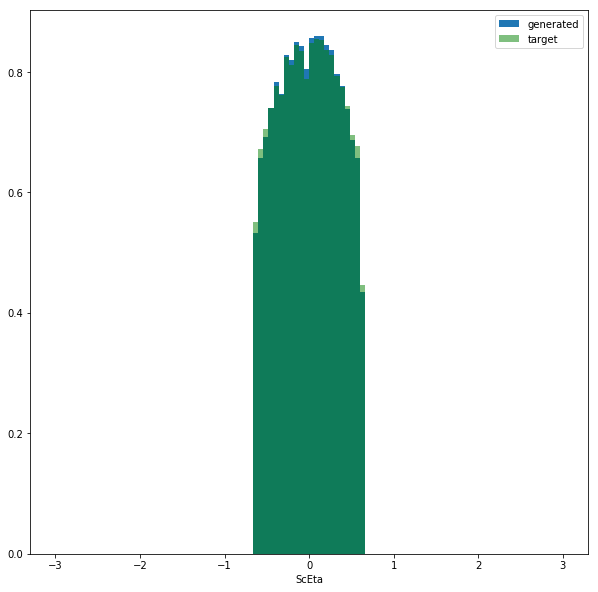

In [26]:
for ix in range(len(x_names)):
    plotting.plot_hists(data_x[:,0,ix],mc_x[:,0,ix],generated_w=mc_w,bins=100,range=[-3,3])
    plt.xlabel(x_names[ix])
    plt.show()

for ic in range(len(c_names)):
    plotting.plot_hists(data_c[:,0,ic],mc_c[:,0,ic],generated_w=mc_w,bins=100,range=[-3,3])
    plt.xlabel(c_names[ic])
    plt.show()


In [27]:
nmax = min(data_x.shape[0]//FRAC_DATA,mc_x.shape[0])

data_x_train,data_x_test,data_c_train,data_c_test,data_w_train,data_w_test = cms.train_test_split(data_x[:nmax],data_c[:nmax],data_w[:nmax])
mc_x_train,mc_x_test,mc_c_train,mc_c_test,mc_w_train,mc_w_test = cms.train_test_split(mc_x[:nmax],mc_c[:nmax],mc_w[:nmax])

wscl = data_w[:nmax].sum() / mc_w[:nmax].sum()
mc_w_train *= wscl
mc_w_test *= wscl

In [28]:
print(nmax,mc_w_train.sum()/data_w_train.sum())

1752021 0.999388825769


In [29]:
from keras.optimizers import RMSprop

if PRETRAIN_G:
    generator = gan.get_generator()
    generator.compile(loss="mse",optimizer=RMSprop(lr=1.e-3))
    generator.fit( [mc_c_train,mc_x_train], [mc_c_train,mc_x_train], sample_weight=[mc_w_train,mc_w_train], epochs=1, batch_size=BATCH_SIZE  )

/users/musella/jupyter/GAN/GAN/base.py:177: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  callbacks = [checkpoint,csv,tensorboard,plotter], **kwargs


calling WeightClip 0.02
calling WeightClip 0.02
calling WeightClip 0.02
calling WeightClip 0.02
calling WeightClip 0.02
calling WeightClip 0.02
calling WeightClip 0.02
calling WeightClip 0.02
calling WeightClip 0.02
calling WeightClip 0.02
calling WeightClip 0.02
calling WeightClip 0.02
Epoch 1/999
1298432/1314015 [============================>.] - ETA: 0s - loss: -1.3485e-12 - discriminator_loss: -2.6722e-04 - discriminator_model_2_loss: -2.9122e-04 - discriminator_D_256x5_output_loss: 2.3998e-05 - generator_loss: 2.6722e-04 - generator_model_3_loss: 2.9122e-04 - generator_D_256x5_output_loss: -2.3998e-05[-0.32245293834791949, 1.6400606636213644]
[-0.33361825984386478, 1.6417539596442903]
[-0.33376912717368157, 1.6386768390442132]
[-0.3319889896736235, 1.6667674403738504]
[-0.32660005872739467, 1.6946130810692928]
[-0.32264211743069937, 1.6330932252956183]
[-0.32727109522711573, 1.7271134926076663]
[-0.22638731740902718, 2.5493012148288048]
[-0.29018316423906754, 1.9036746440976835]
[

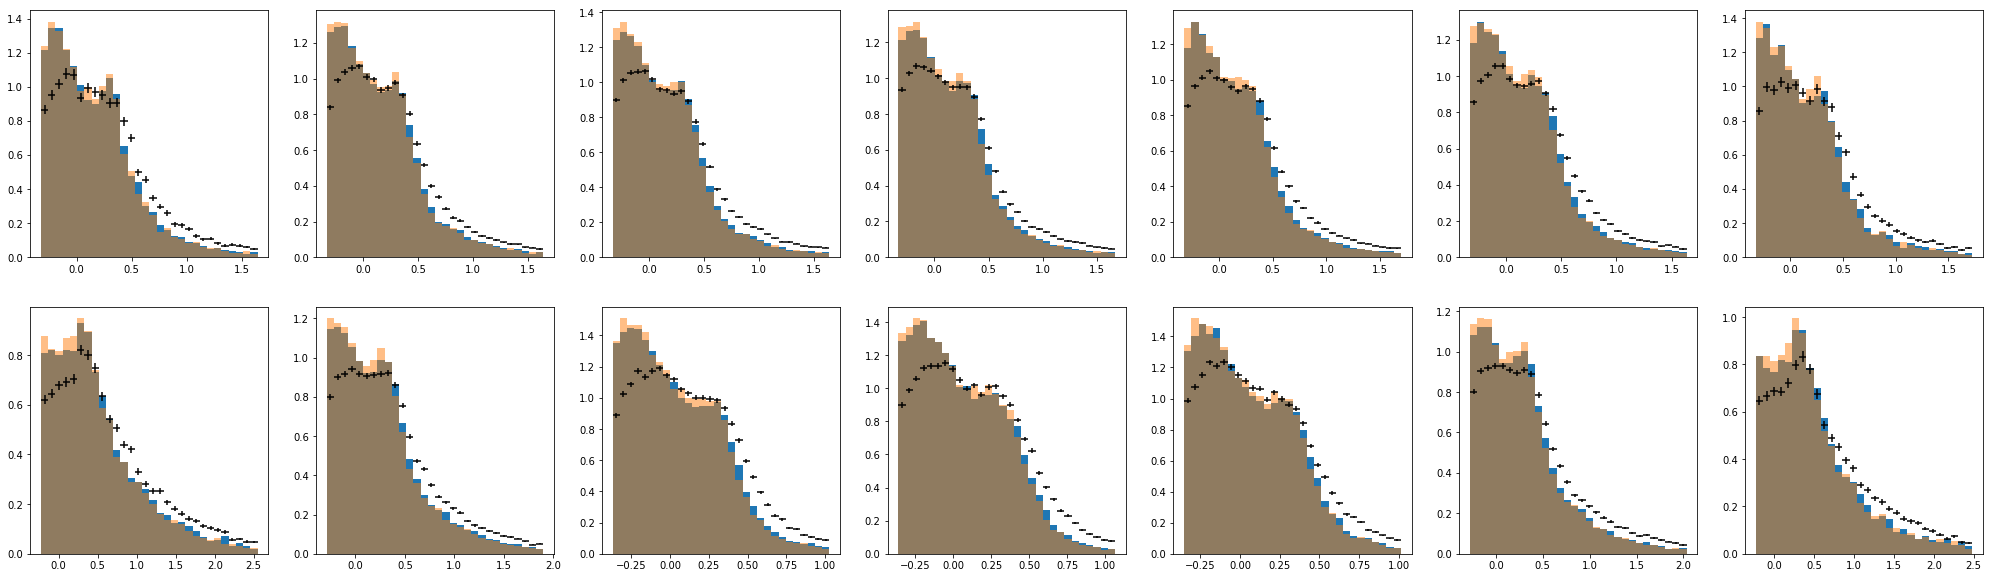

[-0.64635913372039799, 0.20829927386644861]
[-0.65095376297790075, 0.20964556154581376]
[-0.66324942345396853, 0.20933550175918242]
[-0.64177507068174444, 0.2104689321683314]
[-0.66520308256149296, 0.20931680763853511]
[-0.6431137735931205, 0.20997410812458223]
[-0.63781998753547642, 0.20985565443589704]
[-1.0862634420394897, 0.17889141791276791]
[-0.77406203746795654, 0.19116336519051072]
[-0.45465702162920096, 0.21253224822198521]
[-0.33549439038161533, 0.22102031197411978]
[-0.48552648310721858, 0.21055367769677377]
[-0.79791923379675866, 0.19127286919851622]
[-1.0520546600883636, 0.17849120477906028]


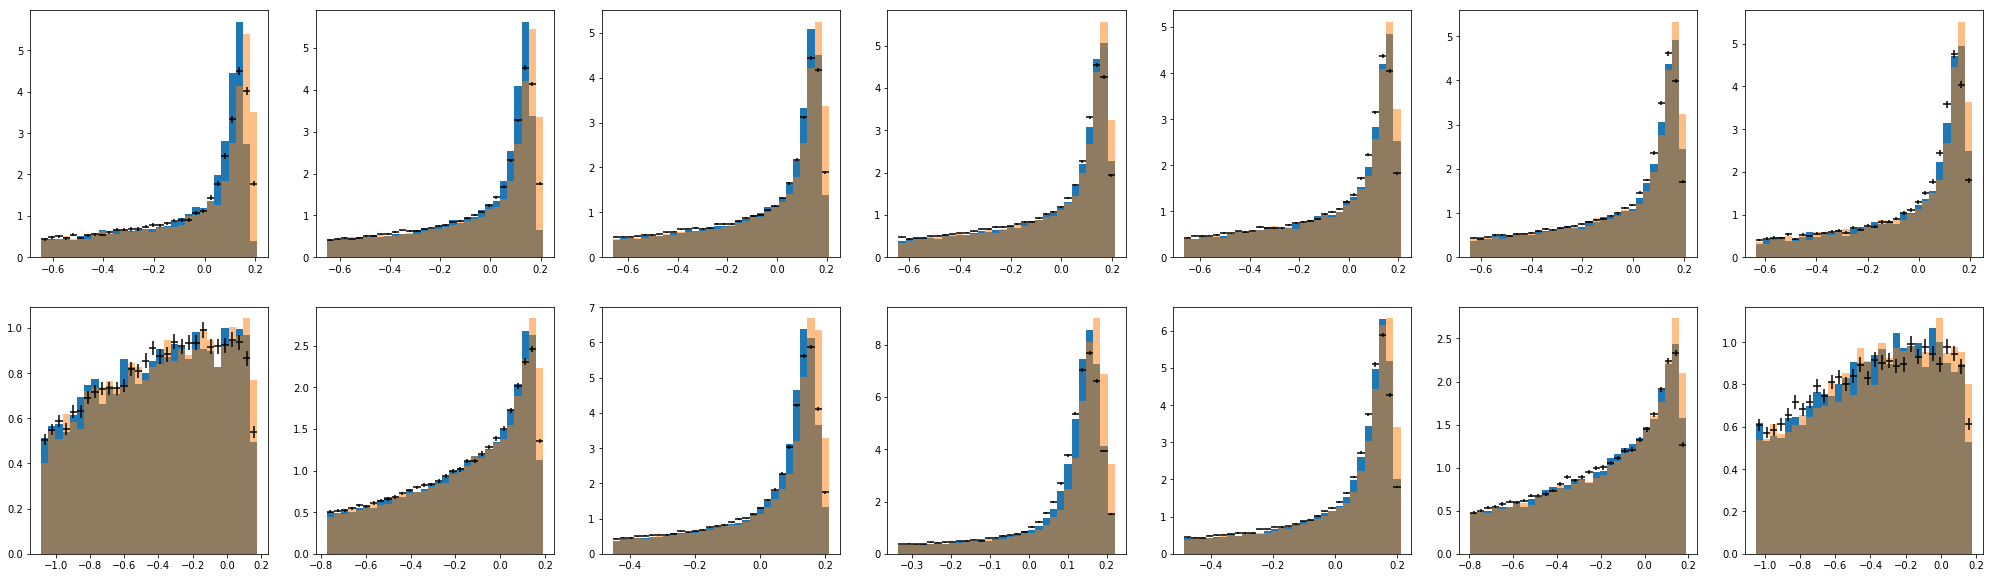

[-0.0052863797172904015, 0.0057352948933839798]


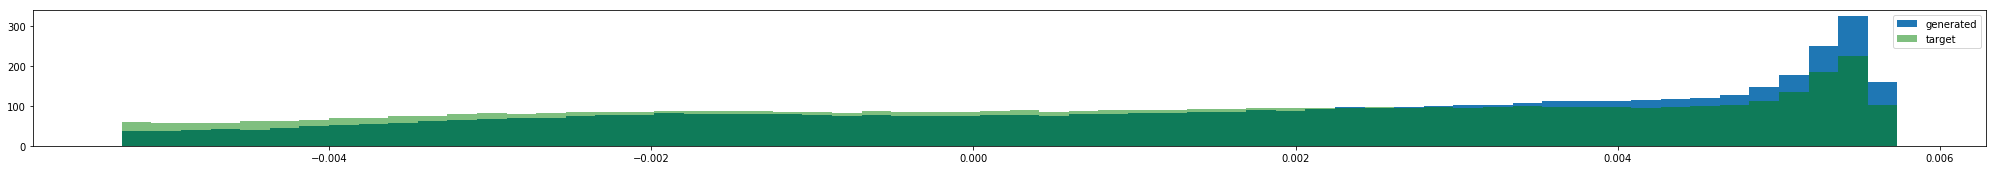

1314015/1314015 [==============================] - 59s - loss: -1.6954e-12 - discriminator_loss: -2.7611e-04 - discriminator_model_2_loss: -3.0003e-04 - discriminator_D_256x5_output_loss: 2.3917e-05 - generator_loss: 2.7611e-04 - generator_model_3_loss: 3.0003e-04 - generator_D_256x5_output_loss: -2.3917e-05    
Epoch 2/999
1314015/1314015 [==============================] - 4s - loss: -2.7658e-11 - discriminator_loss: -0.0028 - discriminator_model_2_loss: -1.1304e-04 - discriminator_D_256x5_output_loss: -0.0027 - generator_loss: 0.0028 - generator_model_3_loss: 1.1304e-04 - generator_D_256x5_output_loss: 0.0027     
Epoch 3/999
1314015/1314015 [==============================] - 4s - loss: 1.1296e-11 - discriminator_loss: -0.0063 - discriminator_model_2_loss: 0.0029 - discriminator_D_256x5_output_loss: -0.0092 - generator_loss: 0.0063 - generator_model_3_loss: -0.0029 - generator_D_256x5_output_loss: 0.0092     
Epoch 4/999
1314015/1314015 [==============================] - 4s - loss: -

In [30]:
reload(base)

initial_epoch = 0
# if hasattr(gan.model,"history"):
#     initial_epoch = gan.model.history.epoch[-1] + 1

do = dict(
    x_train=data_x_train,
    z_train=mc_x_train,
    c_x_train=data_c_train,
    c_z_train=mc_c_train,
    w_x_train = data_w_train,
    w_z_train = mc_w_train,
          
    x_test=data_x_test,
    z_test=mc_x_test,
    c_x_test=data_c_test,
    c_z_test=mc_c_test,
    w_x_test = data_w_test,
    w_z_test = mc_w_test,
    
    n_epochs=EPOCHS + initial_epoch - 1,
    initial_epoch=initial_epoch,
    batch_size=BATCH_SIZE,
    plot_every=PLOT_EVERY,
    
    monitor_dir=MONITOR_DIR
)

base.MyGAN.adversarial_fit(gan,**do)


In [31]:
# mc_x_morphed = gan.get_generator().predict([mc_c_test,mc_x_test])[1]

# data_p = gan.get_discriminator().predict([data_c_test,data_x_test])
# mc_p   = gan.get_discriminator().predict([mc_c_test,mc_x_morphed])

In [32]:
# reload(plotting)

# data_quantiles = np.percentile(data_c_test,[0,5,20,40,60,80,95,100])

# # plotting.plot_summary_cond(data_x_test,data_c_test,mc_x_test,mc_c_test,mc_x_test,data_p,mc_p)
# # plotting.plot_summary_cond(data_x_test,data_c_test,mc_x_morphed,mc_c_test,mc_x_test,data_p,mc_p)
# plotting.plot_summary_cond(data_x_test,data_c_test,mc_x_morphed,mc_c_test,mc_x_test,data_p,mc_p,
#                            do_slices=True,c_bounds=data_quantiles,saveas='wgan_test4.png')


In [33]:
# plt.savefig('wgan_test1.png')